# Setup

**Imports**

In [25]:
import datetime as dt
import geopandas as gpd
import contextily as cx

import matplotlib.pyplot as plt
from math import log
import pandas as pd
import contextily as cx

import IPython
import geopandas
from scipy.linalg import eigh

from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import asin, cos, radians, sin, sqrt

import scipy
from scipy.signal import spectrogram
import ruptures as rpt

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [2]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [3]:
signal = X_train[0]
f, t, Sxx =scipy.signal.spectrogram(signal, fs=FS)
Sxx = np.log10(Sxx)

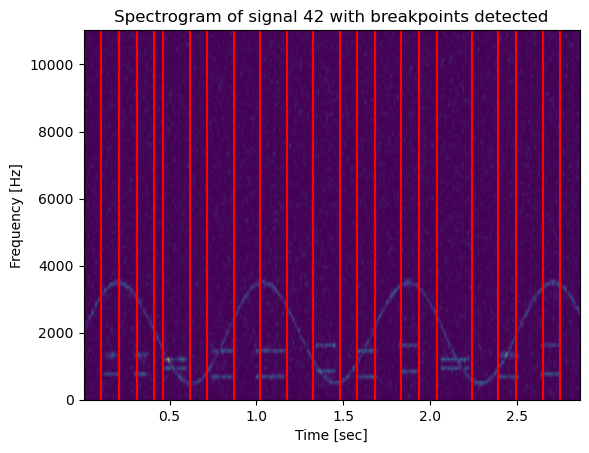

In [4]:
def get_breakpoints_and_freqs(signal, num_bkps=2) : 
    f, t, Sxx =scipy.signal.spectrogram(signal, fs=FS)
    Sxx = np.log10(Sxx)

    spec_reduced = np.zeros((3, len(t)))
    spectro = np.zeros(Sxx.shape[1])

    for i in range(len(Sxx[0])) : 
        indexs = np.argpartition(Sxx[:, i], -3)[-3:]
        spectro[i] = np.average(f[indexs], weights=Sxx[indexs, i])
        indexs.sort()
        spec_reduced[:, i] = f[indexs]
    
    algo = rpt.Dynp(model='l2').fit(spectro)
    bkps = algo.predict(n_bkps=num_bkps)
    
    res=[]

    if len(bkps)%2==0 : 
        bkps.append(len(t)-1)
    for i in range( len(bkps)//2)  : 
        bkp_inf = bkps[2*i]
        bkp_sup = bkps[2*i+2]
        spectro_reduced = spec_reduced[: , bkp_inf:bkp_sup].flatten()
        spectro_reduced=spectro_reduced[spectro_reduced<2000]
        histo , edges = np.histogram(spectro_reduced, bins = 150)
        bin_centers = (edges[:-1] + edges[1:]) / 2

        top_two_indices = np.argsort(histo)[-2:]  # Get indices of two largest bins

        top_two_locations = bin_centers[top_two_indices]
        top_two_locations.sort()
        res.append(top_two_locations)
    return [t[bkp] for bkp in bkps if bkp < len(t)], res


index=42
signal=X_train[index]
f, t, Sxx =scipy.signal.spectrogram(signal, fs=FS)
plt.pcolormesh((t), f, Sxx, shading='gouraud')
t, res = get_breakpoints_and_freqs(signal, len(y_train[index])*2)
plt.vlines(t, 0,np.max(f), color="r")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.title(f"Spectrogram of signal {index} with breakpoints detected")
plt.show()

In [5]:
symbols = set() # set of all symbols in the dataset
for i in range(len(y_train)) : 
    set_here = set(y_train[i])
    symbols = symbols.union(set_here)
symbols = list(symbols)
my_dico= {symbols[i]: [] for i in range(len(symbols))}
for i in range(len(X_train)): # for each signal we get the breakpoints and the frequencies of the symbols
    signal = X_train[i]
    symbole_of_the_signal = y_train[i]
    t, res = get_breakpoints_and_freqs(signal, len(symbole_of_the_signal)*2)
    for j in range(len(symbole_of_the_signal)) : 
        my_dico[symbole_of_the_signal[j]].append(res[j])
        
    
    


In [6]:
for key in my_dico.keys() : # median
    my_dico[key] = np.median(np.array(my_dico[key]).T[0]), np.median(np.array(my_dico[key]).T[1])

In [7]:
my_dico

{'*': (948.322265625, 1205.859375),
 'C': (863.7685546875, 1633.7958984375),
 '9': (863.05078125, 1465.693359375),
 '7': (863.05078125, 1205.859375),
 'A': (690.2109375, 1634.80078125),
 '#': (950.044921875, 1467.5595703125),
 'B': (777.779296875, 1634.0830078125),
 '3': (691.646484375, 1465.98046875),
 '6': (775.482421875, 1462.822265625),
 '8': (863.05078125, 1375.828125),
 '1': (691.072265625, 1205.4287109375),
 '4': (776.630859375, 1205.859375),
 '0': (948.896484375, 1375.25390625),
 '5': (777.205078125, 1374.2490234375),
 '2': (691.359375, 1296.298828125),
 'D': (950.044921875, 1637.384765625)}

In [8]:
def get_symbol(res): 
    symbols = []
    for r in res : 
        freq_inf=r[0]
        freq_sup=r[1]
        error = np.inf 
        for sym in my_dico.keys() : 
            freq_inf_ref = my_dico[sym][0]
            freq_sup_ref = my_dico[sym][1]
            error_here = (freq_inf-freq_inf_ref)**2 + (freq_sup-freq_sup_ref)**2
            if error_here < error : 
                error = error_here
                symbol = sym
        symbols.append(symbol)
    return symbols

    

# Question 2

In [9]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()
y_test  = np.load("y_test.npy", allow_pickle=True).tolist()

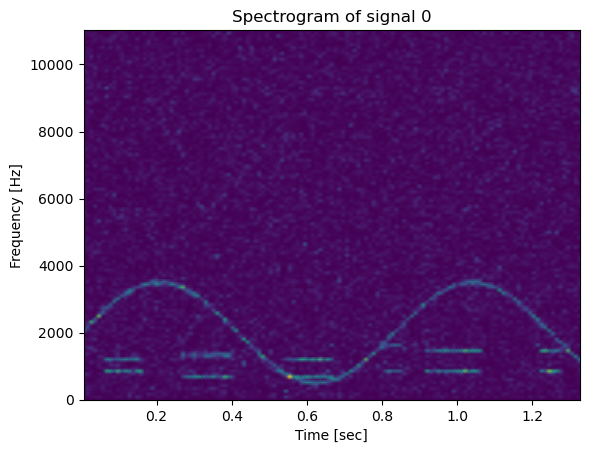

We identify 6 symbols  in the signal 0


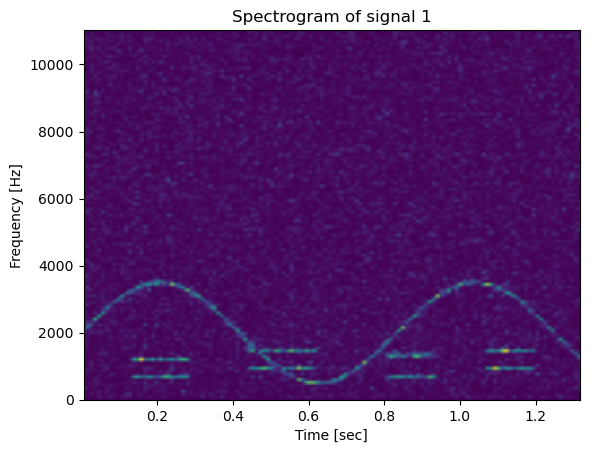

We identify 4 symbols  in the signal 1


In [10]:
signal1 = X_test[0]
f, t, Sxx =scipy.signal.spectrogram(signal1, fs=FS)
plt.pcolormesh((t), f, Sxx, shading='gouraud')
plt.xlabel("Time [sec]")    
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram of signal 0")
plt.show()
print('We identify 6 symbols  in the signal 0')
signal2 = X_test[1]
f, t, Sxx =scipy.signal.spectrogram(signal2, fs=FS)
plt.pcolormesh((t), f, Sxx, shading='gouraud')
plt.xlabel("Time [sec]")    
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram of signal 1")
plt.show()
print('We identify 4 symbols  in the signal 1')

In [11]:

print('premier essai')
signal, symbols= X_test[0], y_test[0]
t, res = get_breakpoints_and_freqs(signal, num_bkps=2*6)
print('vraie valeur: ')

print(symbols)
print('prediction: ')
print(get_symbol(res))
print()
print('deuxieme essai')
signal, symbols= X_test[1], y_test[1]
t, res = get_breakpoints_and_freqs(signal, num_bkps=2*4)
print('vraie valeur: ')
print(symbols)
print('prediction: ')
print(get_symbol(res))

premier essai
vraie valeur: 
['7', '2', '1', 'C', '9', '9']
prediction: 
['7', '2', '1', 'C', '9', '9']

deuxieme essai
vraie valeur: 
['1', '#', '2', '#']
prediction: 
['1', '#', '2', '#']


# Question 3

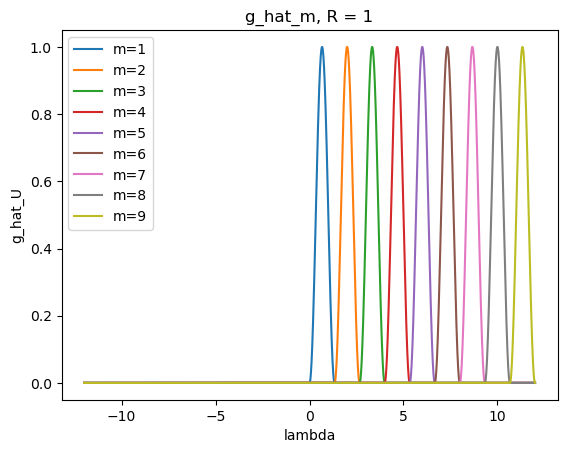

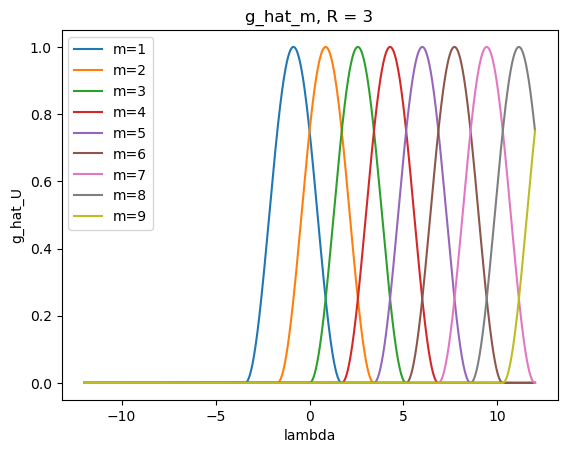

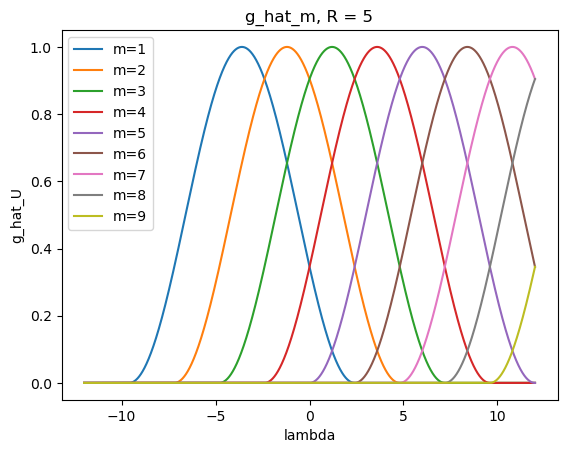

In [12]:
# R=3
def g_hat_U(lam, a , r): 
    if lam < 0 and lam > -a*r :
        return 0.5*(1+np.cos(2*np.pi*(0.5 + lam/(a*r))))
    else : 
        return 0

def g_hat_m(lamb, m, a, r): 
    return g_hat_U(lamb - a*m, a, r)

M=9

for R in [1, 3, 5]: 
    x= np.linspace(-12, 12, 10000)
    lambda_n = 12
    a = lambda_n/(M+1-R)
    for m in range(1, M+1): 
        y= [ g_hat_m(lamb, m, a, R) for lamb in x]
        plt.plot(x, y, label=f"m={m}")
    plt.legend()
    plt.title(f"g_hat_m, R = {R}")
    plt.xlabel("lambda")
    plt.ylabel("g_hat_U")
    plt.show()


# Question 4

In [13]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from pygsp import graphs

def get_grid_graph(n_nodes_height=10, n_nodes_width=10) -> graphs.Graph:
    """Return a 2D grid graph."""
    g = graphs.Grid2d(n_nodes_height, n_nodes_width)
    xx, yy = np.meshgrid(np.arange(n_nodes_height), np.arange(n_nodes_width))
    coords = np.array((xx.ravel(), yy.ravel())).T
    g.set_coordinates(coords)
    g.compute_laplacian("combinatorial")
    return g


CRS = "EPSG:4326"

STATION_LIST = [
    "ARZAL",
    "AURAY",
    "BELLE ILE-LE TALUT",
    "BIGNAN",
    "BREST-GUIPAVAS",
    "BRIGNOGAN",
    "DINARD",
    "GUERANDE",
    "ILE DE GROIX",
    "ILE-DE-BREHAT",
    "KERPERT",
    "LANDIVISIAU",
    "LANNAERO",
    "LANVEOC",
    "LORIENT-LANN BIHOUE",
    "LOUARGAT",
    "MERDRIGNAC",
    "NOIRMOUTIER EN",
    "OUESSANT-STIFF",
    "PLEUCADEUC",
    "PLEYBER-CHRIST SA",
    "PLOERMEL",
    "PLOUDALMEZEAU",
    "PLOUGUENAST",
    "PLOUMANAC'H",
    "POMMERIT-JAUDY",
    "PONTIVY",
    "PTE DE CHEMOULIN",
    "PTE DE PENMARCH",
    "PTE DU RAZ",
    "QUIMPER",
    "QUINTENIC",
    "ROSTRENEN",
    "SAINT-CAST-LE-G",
    "SARZEAU SA",
    "SIBIRIL S A",
    "SIZUN",
    "SPEZET",
    "ST BRIEUC",
    "ST NAZAIRE-MONTOIR",
    "ST-SEGAL S A",
    "THEIX",
    "VANNES-SENE",
]

In [14]:
data_df, stations_df, description = load_molene_meteo_dataset()


In [15]:
# only keep a subset of stations
keep_cond = stations_df.Nom.isin(STATION_LIST)
stations_df = stations_df[keep_cond]
keep_cond = data_df.station_name.isin(STATION_LIST)
data_df = data_df[keep_cond].reset_index().drop("index", axis="columns")

# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius



# sns.heatmap(dist_mat_square, xticklabels=stations_df.Nom, yticklabels=stations_df.Nom)

In [16]:
def get_geodesic_distance(point_1, point_2) -> float:


    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

Stations with missing values : 

In [17]:
missing_values_station=[]
for station_name in STATION_LIST: 
    data_df_mystation = data_df[data_df["station_name"] == station_name]
    if (len(data_df_mystation['t'])) < 744 :
        print(station_name)
        missing_values_station.append(station_name)
        print(len(data_df_mystation['t']))
station_list_clean=[name for name in STATION_LIST if name not in missing_values_station]

ARZAL
743
BREST-GUIPAVAS
743
BRIGNOGAN
743
LANDIVISIAU
743
LANNAERO
707
LANVEOC
743
OUESSANT-STIFF
743
QUIMPER
743
ST NAZAIRE-MONTOIR
677


In [18]:
station_cleaned = stations_df[stations_df.Nom.isin(station_list_clean)]


In [19]:
# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    station_cleaned,
    geometry=geopandas.points_from_xy(station_cleaned.Longitude, station_cleaned.Latitude),
).set_crs(CRS)


In [20]:

stations_np = station_cleaned[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)


In [21]:
def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

In [22]:
def is_connected(graph) -> bool:
    L = graph.L.todense()
    eigenvalues, _ = eigh(L)
    return (eigenvalues[1] < 1e-6).sum()

average degree = 2* vertices/nodes

In [122]:
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.85
adjacency_matrix_gaussian = squareform(

    get_exponential_similarity(dist_mat_condensed, sigma, 0.74)
)
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
# print(
#     f"The graph is {'not ' if not is_connected(G_gaussian) else ''}connected, with {G_gaussian.N} nodes, {G_gaussian.Ne} edges"
# )
print('average degree: ', 2*G_gaussian.Ne/G_gaussian.N)
print('threshold, ' , 0.74)

average degree:  5.823529411764706
threshold,  0.74


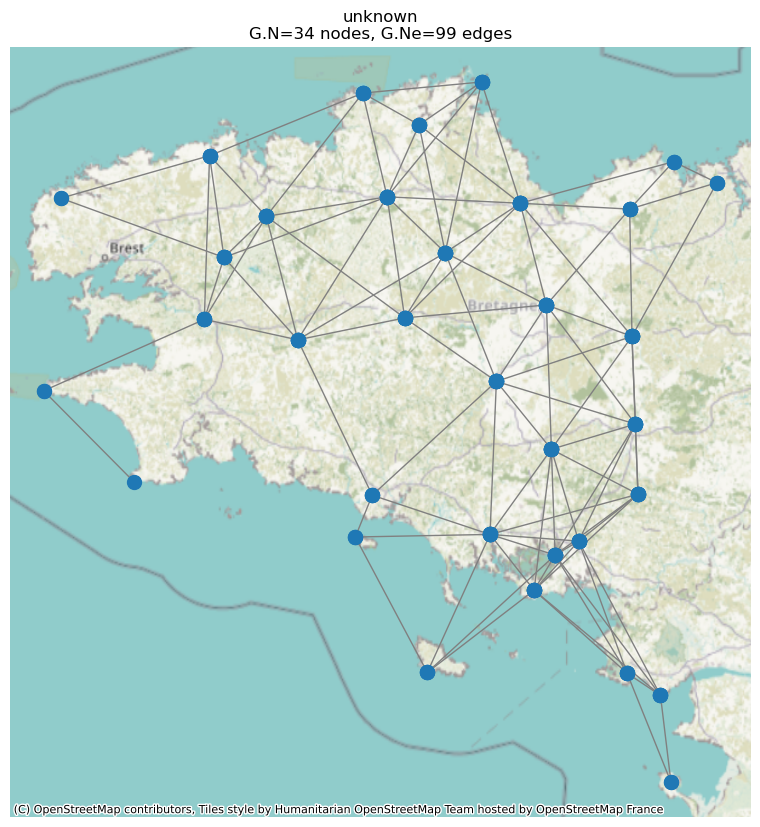

In [24]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot(ax = ax)
plt.show()

Text(0.5, 1.0, 'Temperature at 1:00 AM')

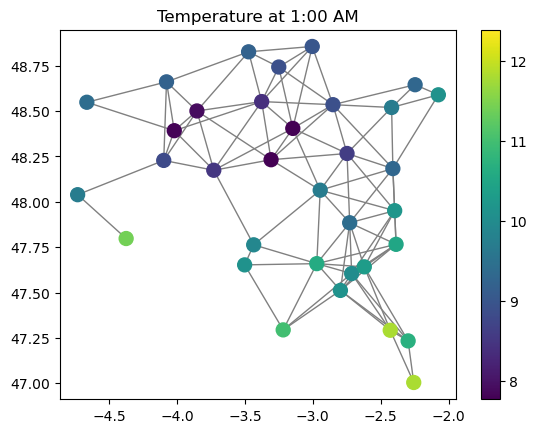

In [48]:
# Assuming 'choosen_hour' is the fixed time t
choosen_hour = pd.to_datetime("2014-01-02 01:00:00")

# Filter the data to get the temperatures at the specified time
temp_at_t = data_df[data_df['date'] == choosen_hour][['station_name', 't']]

# Merge with station coordinates
stations_temp = station_cleaned.merge(temp_at_t, left_on='Nom', right_on='station_name')

# Convert to GeoDataFrame
stations_temp_gdf = gpd.GeoDataFrame(
    stations_temp,
    geometry=gpd.points_from_xy(stations_temp.Longitude, stations_temp.Latitude),
    crs=CRS
)
G_gaussian.plot_signal(np.array(stations_temp_gdf['t']) -273.15, vertex_size=100)
plt.title('Temperature at 1:00 AM')



In [58]:
# get smoothness of a signal 
def get_smoothness(signal, graph, laplacian, tau=1e-4):
    return signal @ laplacian @ signal / (signal @ signal) + tau
get_smoothness(np.array(stations_temp_gdf['t']) -273.15, G_gaussian, G_gaussian.L.todense()).item()

0.021791012215044862

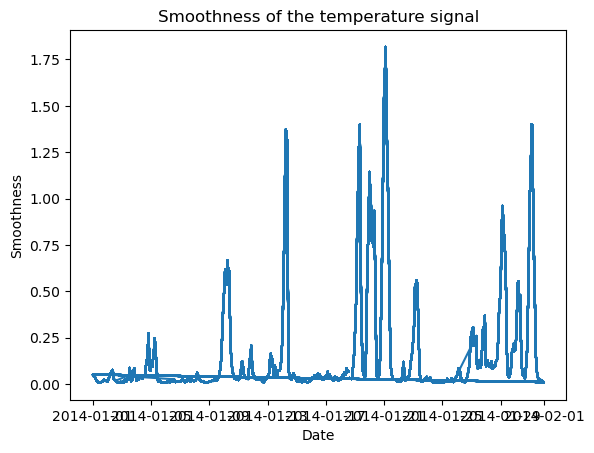

In [ ]:
dates = pd.to_datetime(data_df['date'])
smoothnesses=[]
for date in dates : 
    # Assuming 'choosen_hour' is the fixed time t
    choosen_hour = date

    # Filter the data to get the temperatures at the specified time
    temp_at_t = data_df[data_df['date'] == choosen_hour][['station_name', 't']]

    # Merge with station coordinates
    stations_temp = station_cleaned.merge(temp_at_t, left_on='Nom', right_on='station_name')

    # Convert to GeoDataFrame
    stations_temp_gdf = gpd.GeoDataFrame(
        stations_temp,
        geometry=gpd.points_from_xy(stations_temp.Longitude, stations_temp.Latitude),
        crs=CRS
    )
    smoothness = get_smoothness(np.array(stations_temp_gdf['t']) -273.15, G_gaussian, G_gaussian.L.todense()).item()
    smoothnesses.append(smoothness)


In [73]:
smoothness_without_nan =[]
dates_without_nan = []
for i in range(len(smoothnesses)): 
    if not np.isnan(smoothnesses[i]): 
        smoothness_without_nan.append(smoothnesses[i])
        dates_without_nan.append(dates[i])
    


In [83]:
dates_without_nan[np.argmin(smoothness_without_nan)], dates_without_nan[np.argmax(smoothness_without_nan)]

(Timestamp('2014-01-24 23:00:00'), Timestamp('2014-01-21 02:00:00'))

In [124]:
dates_without_nan[np.argmin(smoothness_without_nan)]

Timestamp('2014-01-24 23:00:00')

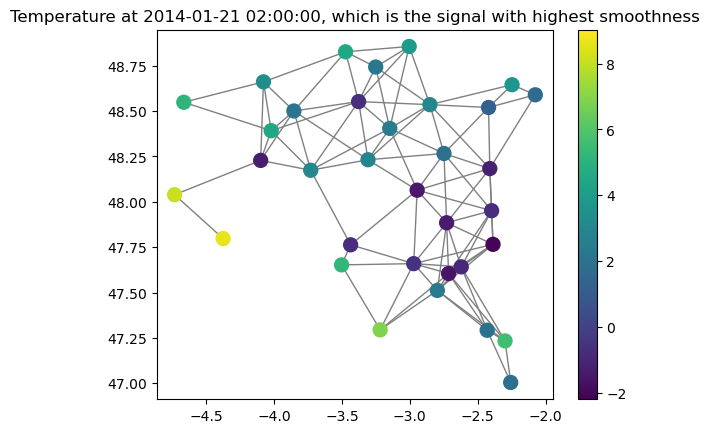

In [104]:
# Assuming 'choosen_hour' is the fixed time t
choosen_hour = dates_without_nan[np.argmax(smoothness_without_nan)]

# Filter the data to get the temperatures at the specified time
temp_at_t = data_df[data_df['date'] == choosen_hour][['station_name', 't']]

# Merge with station coordinates
stations_temp = station_cleaned.merge(temp_at_t, left_on='Nom', right_on='station_name')

# Convert to GeoDataFrame
stations_temp_gdf = gpd.GeoDataFrame(
    stations_temp,
    geometry=gpd.points_from_xy(stations_temp.Longitude, stations_temp.Latitude),
    crs=CRS
)
less_smooth = np.array(stations_temp_gdf['t']) -273.15
G_gaussian.plot_signal(np.array(stations_temp_gdf['t']) -273.15, vertex_size=100)
plt.title('Temperature at '+str(choosen_hour) + ', which is the signal with highest smoothness')
plt.show()


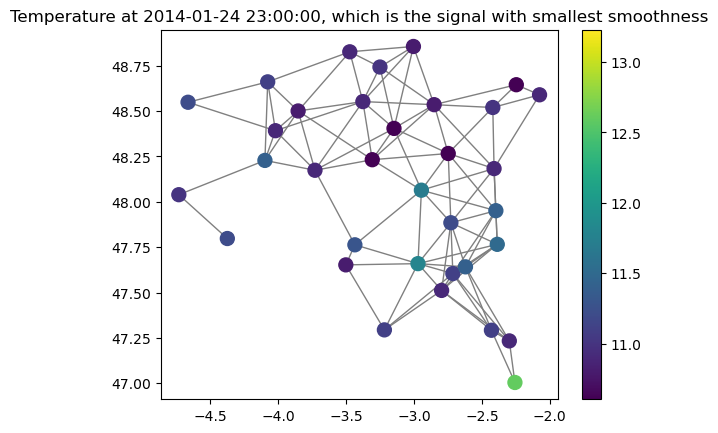

In [105]:
# Assuming 'choosen_hour' is the fixed time t
choosen_hour = dates_without_nan[np.argmin(smoothness_without_nan)]

# Filter the data to get the temperatures at the specified time
temp_at_t = data_df[data_df['date'] == choosen_hour][['station_name', 't']]

# Merge with station coordinates
stations_temp = station_cleaned.merge(temp_at_t, left_on='Nom', right_on='station_name')

# Convert to GeoDataFrame
stations_temp_gdf = gpd.GeoDataFrame(
    stations_temp,
    geometry=gpd.points_from_xy(stations_temp.Longitude, stations_temp.Latitude),
    crs=CRS
)
smoothest = np.array(stations_temp_gdf['t']) -273.15

G_gaussian.plot_signal(np.array(stations_temp_gdf['t']) -273.15, vertex_size=100)
plt.title('Temperature at '+str(choosen_hour) + ', which is the signal with smallest smoothness')
plt.show()

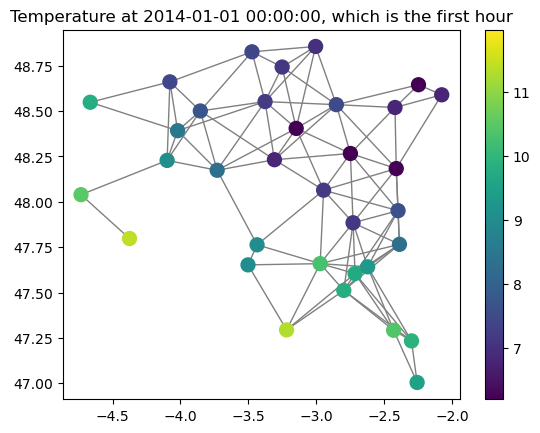

In [106]:
# Assuming 'choosen_hour' is the fixed time t
choosen_hour = dates_without_nan[0]

# Filter the data to get the temperatures at the specified time
temp_at_t = data_df[data_df['date'] == choosen_hour][['station_name', 't']]

# Merge with station coordinates
stations_temp = station_cleaned.merge(temp_at_t, left_on='Nom', right_on='station_name')

# Convert to GeoDataFrame
stations_temp_gdf = gpd.GeoDataFrame(
    stations_temp,
    geometry=gpd.points_from_xy(stations_temp.Longitude, stations_temp.Latitude),
    crs=CRS
)
first_signal = np.array(stations_temp_gdf['t']) -273.15
G_gaussian.plot_signal(np.array(stations_temp_gdf['t']) -273.15, vertex_size=100)
plt.title('Temperature at '+str(choosen_hour) + ', which is the first hour')
plt.show()

# Question 5

In [118]:
# get eigenvectors of the graph
eigenvalues, eigenvectors = eigh(G_gaussian.L.todense())
M=9
R=3
lambda_max = np.max(eigenvalues)
a = lambda_max/(M+1-R)

def get_fourier_transform(signal, graph): 
    return graph.U.T @ signal

def W(signal_fourierise, m, node): 
    res = 0 
    for i in range(G_gaussian.N): 
        res+=g_hat_m(eigenvalues[i], m,a, R ) * signal_fourierise[node]
    return res  

def get_features(node, signal_fourierise): 
    res=[]
    for m in range(1, M+1): 
        res.append(W(signal_fourierise, m, node))
    return np.array(res)

def classify_node(node, signal_fourierise): 
    features = np.array(get_features(node, signal_fourierise))
    # features = features **2
    # print(len(features))
    sum1=np.sum(features[:3])
    sum2=np.sum(features[3:6])
    sum3=np.sum(features[6:])
    if sum1> sum2 and sum1> sum3 : 
        return 1
    elif sum2> sum1 and sum2> sum3 :
        return 2
    else :
        return 3


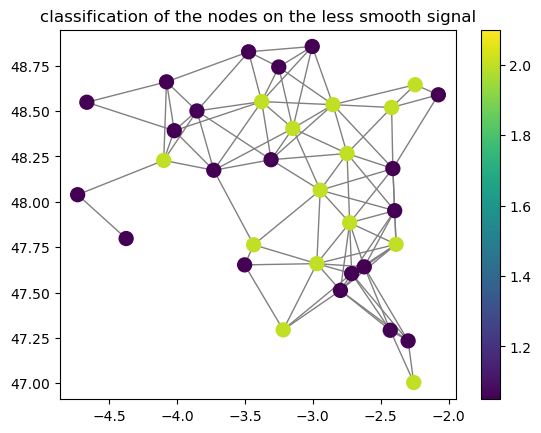

In [119]:
classification = []
for node in range(len(first_signal)): 
    signal_fourierise = get_fourier_transform(first_signal, G_gaussian)
    classification.append(classify_node(node, signal_fourierise))
# plot 

G_gaussian.plot_signal(np.array(classification), vertex_size=100)
plt.title('classification of the nodes on the less smooth signal')
plt.show()

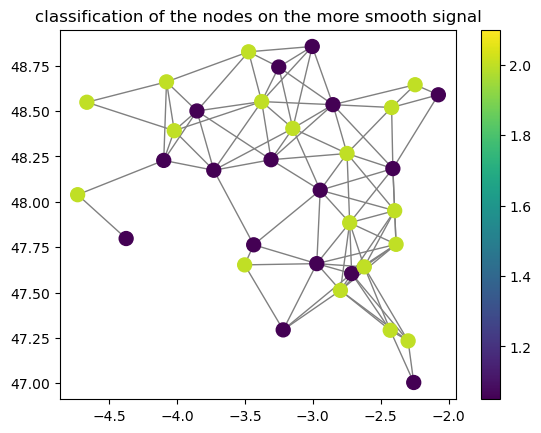

In [126]:
classification = []
for node in range(len(less_smooth)): 
    signal_fourierise = get_fourier_transform(less_smooth, G_gaussian)
    classification.append(classify_node(node, signal_fourierise))
# plot 
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(np.array(classification), vertex_size=100)
plt.title('classification of the nodes on the more smooth signal')
plt.show()

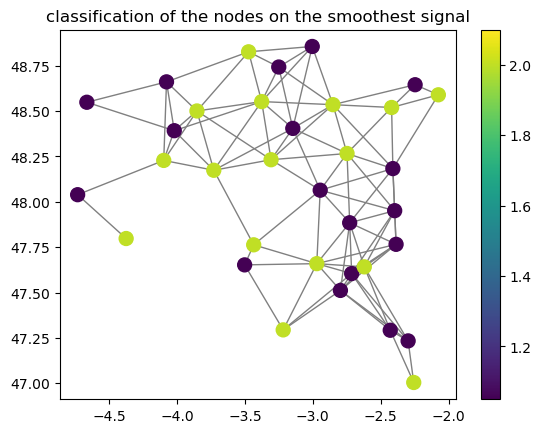

In [121]:
classification = []
for node in range(len(smoothest)): 
    signal_fourierise = get_fourier_transform(smoothest, G_gaussian)
    classification.append(classify_node(node, signal_fourierise))
# plot 

G_gaussian.plot_signal(np.array(classification), vertex_size=100)
plt.title('classification of the nodes on the smoothest signal')
plt.show()

# Question 6

# Question 7